<a href="https://colab.research.google.com/github/WuzI38/Data/blob/Jupyter/MidiGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second attempt on music generation

## Download data

In [177]:
!pip install -q kaggle

In [178]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [179]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [180]:
!kaggle datasets download programgeek01/anime-music-midi

anime-music-midi.zip: Skipping, found more recently modified local copy (use --force to force download)


In [181]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

In [182]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

installing lilypond...
installing fluidsynth...


## Loading and preprocessing

### Parsing files

In [183]:
import os
from music21 import *
from fractions import Fraction

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

In [184]:
midi_list[0]

<music21.stream.Score 0x7eff50347d30>

### Extracting notes and chords



In [185]:
def fragmentise(midi_stream):
  return [part.flat.notes for part in midi_stream.parts]

In [186]:
def signature(midi_stream):
  sig = midi_stream.getTimeSignatures()[0]
  return [sig.numerator, sig.denominator]

In [187]:
frag = fragmentise(midi_list[2])
frag

[<music21.stream.iterator.StreamIterator for Part:0x7eff4f79df40_flat @:0>]

In [188]:
sg = signature(frag[0])
sg

[4, 4]

In [189]:
# Part one - extract notes from both streams and save them into a list
def get_all_notes(midi_piece):
  all_notes = list()
  note_types = set()
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      pitch = str(max(0.0, nt.pitch.ps))
    elif isinstance(nt, chord.Chord):
      pitch = sorted([str(max(0.0, n.ps)) for n in nt.pitches])
      pitch = ' '.join(pitch)
    ql = nt.duration.quarterLength
    all_notes.append([nt.offset, pitch, ql if ql > 0.0 else 0.25]) # If for some reason len is 0 replace it with 0.25
  return all_notes
  
notes_list = get_all_notes(midi_list[1])
notes_list[:10]

[[0.0, '87.0', 0.5],
 [1.0, '80.0', Fraction(1, 3)],
 [2.0, '82.0', Fraction(1, 3)],
 [3.5, '80.0', 0.25],
 [3.75, '82.0', 0.25],
 [4.0, '84.0', 0.25],
 [4.5, '80.0', 0.25],
 [5.0, '75.0', 0.25],
 [5.5, '67.0 72.0', 1.0],
 [6.5, '73.0', 0.25]]

In [190]:
# Part 2 extract all chord types from the dataset
import numpy as np

def get_chord_types(dataset):
  chord_types = dict()
  for d in dataset:
    notes_list = np.array(get_all_notes(d))
    strings = notes_list[:, 1]
    for s in strings:
      chord_types[s] = 1 + chord_types[s] if chord_types.get(s) is not None else 1
  return chord_types

types = get_chord_types(midi_list)

In [191]:
print(len(types))

1881


### Counting invidual chords and removing the rare ones

In [192]:
chord_counts = dict()
for item in sorted(list(types.values())):
  chord_counts[str(item)] = 1 + chord_counts[str(item)] if chord_counts.get(str(item)) is not None else 1

chord_counts = {k: v for k, v in chord_counts.items() if v > 1}

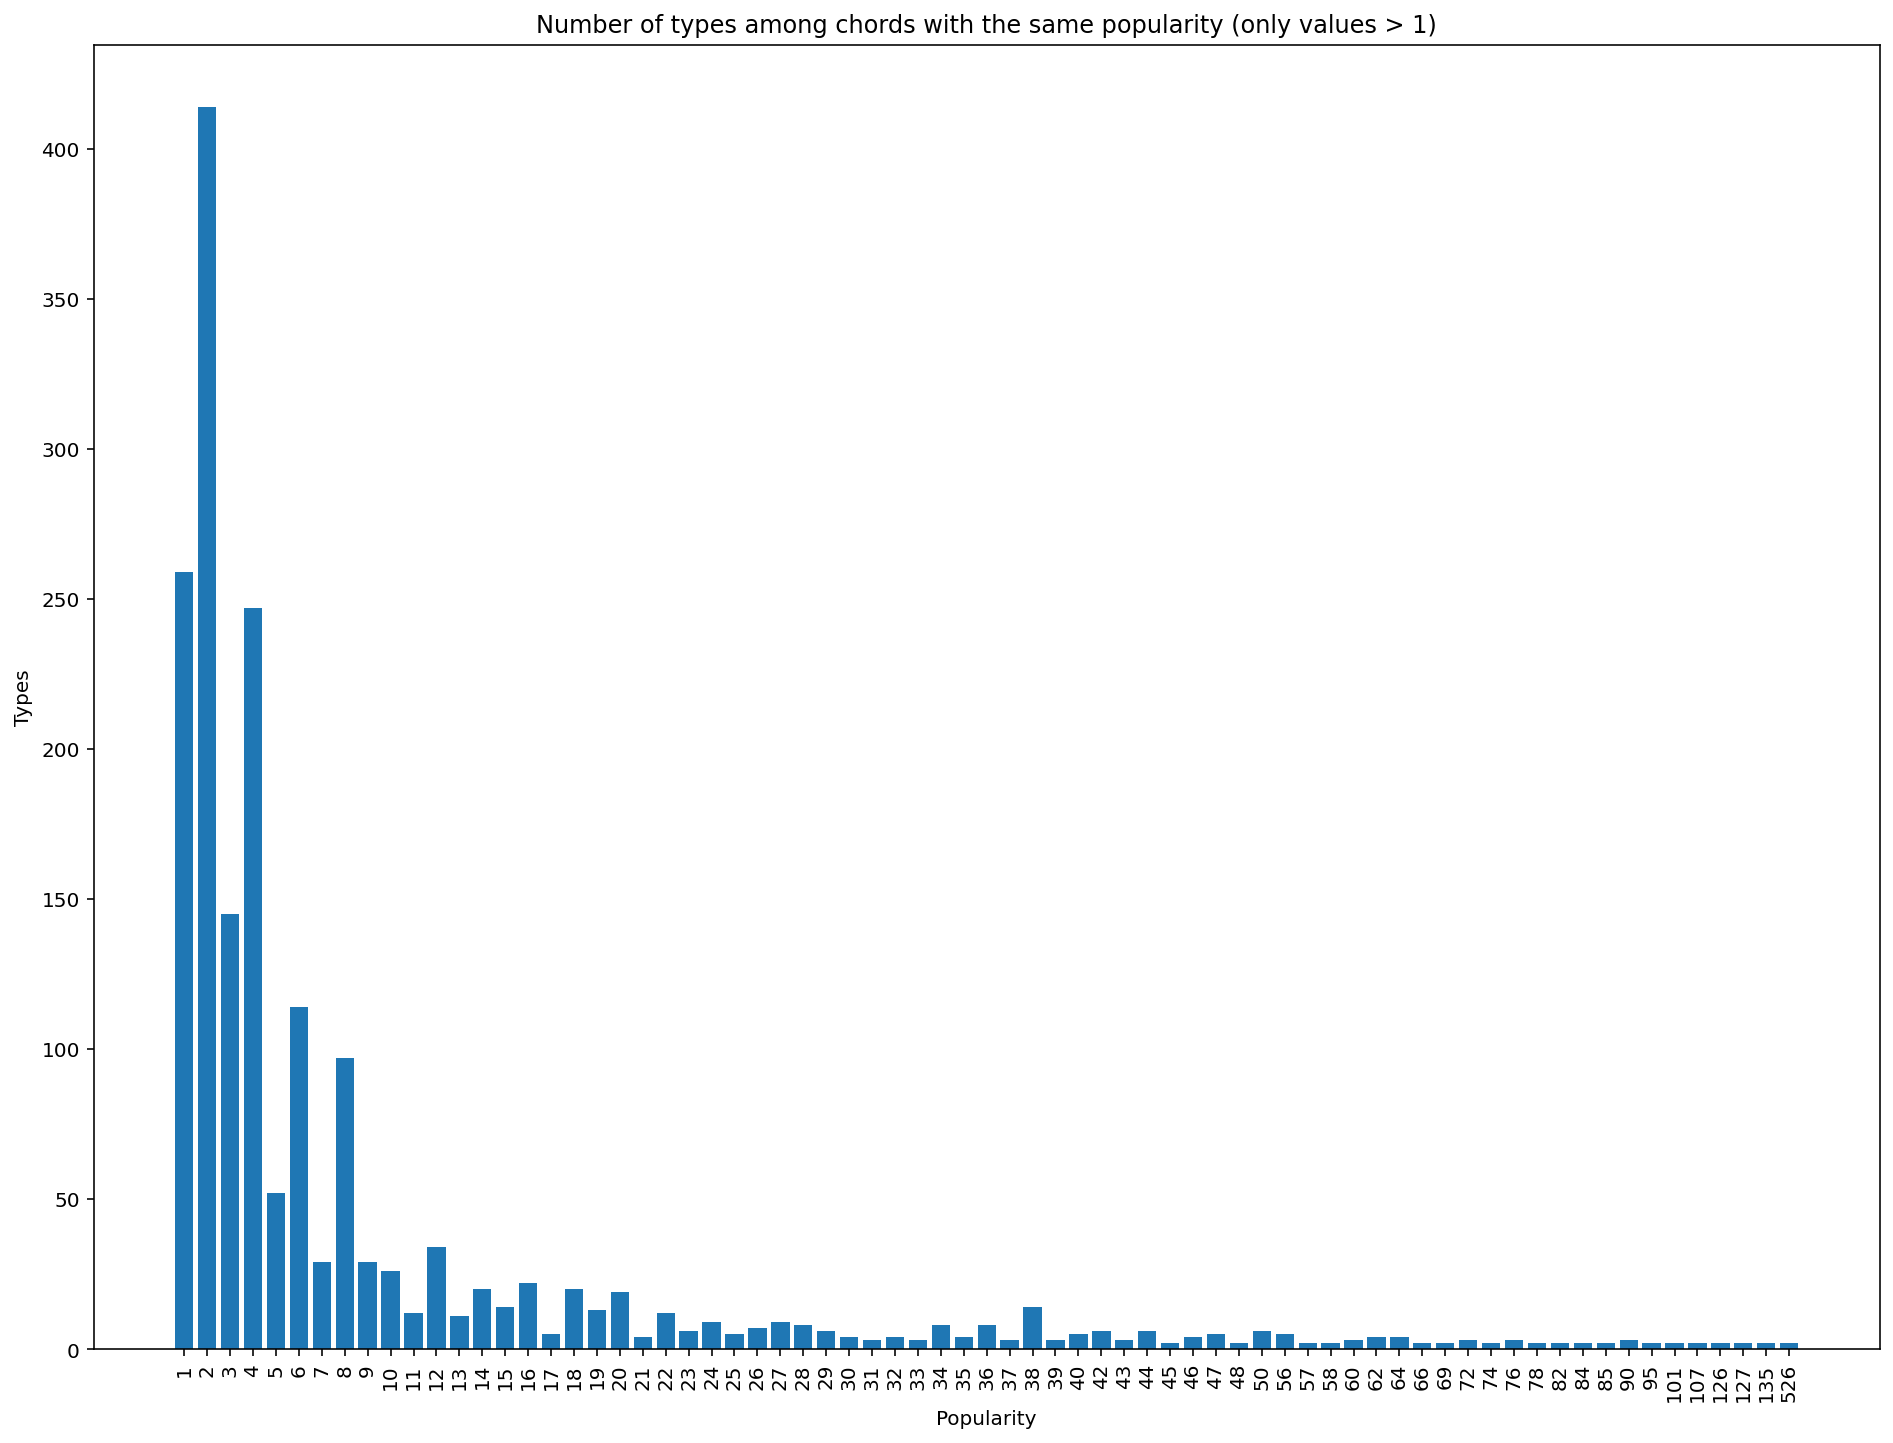

In [193]:
# Plotting the values
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary as lists
keys = list(chord_counts.keys())
values = list(chord_counts.values())

# Change size
plt.figure(figsize=(16, 12))

# Create a bar chart using the plot function
plt.bar(keys, values)

# Add a title and axis labels
plt.title('Number of types among chords with the same popularity (only values > 1)')
plt.xlabel('Popularity')
plt.ylabel('Types')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [194]:
from statistics import mean
HOW_MANY = 20
means = [mean([len(k)//4 for k, v in types.items() if v <= i]) for i in range(1, HOW_MANY + 1)]

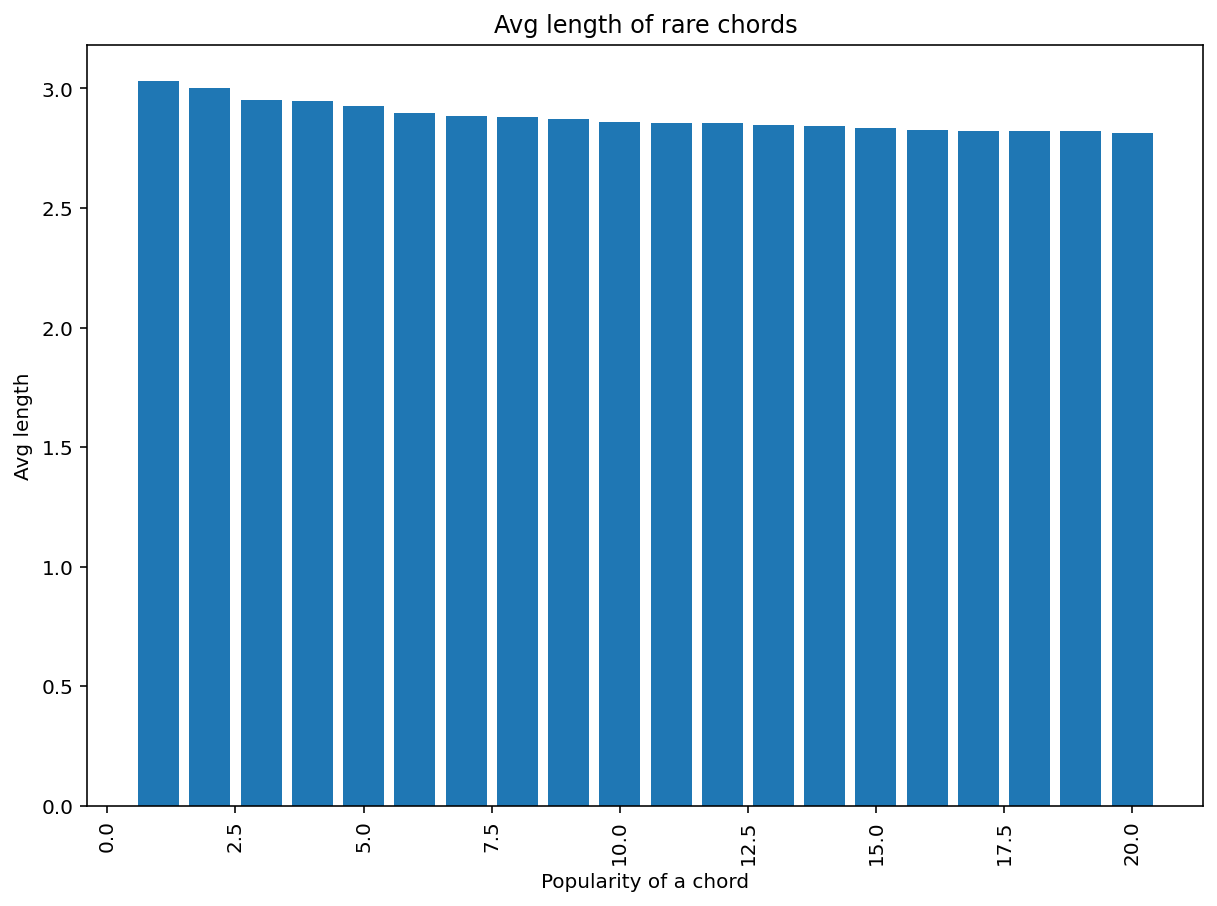

In [195]:
# Plotting the means
plt.figure(figsize=(10, 7))

# Create a bar chart using the plot function
plt.bar(list(range(1, HOW_MANY + 1)), means)

# Add a title and axis labels
plt.title('Avg length of rare chords')
plt.xlabel('Popularity of a chord')
plt.ylabel('Avg length')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

The avg length is around 3 for the rare chords, so I can probably shorten them to 2 notes for the encoding purposes, so i don't have to use 1881 different values

## Visualize melodies

In [196]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
    try:
        filename = music.write('mid')
        os.system(f'fluidsynth -ni font.sf2 {filename} -F {filename}.wav -r 16000 > /dev/null')
        display(Audio(f'{filename}.wav'))
    except Exception as e:
        print(f'Error: {e}')

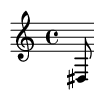

In [197]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(Fraction(1, 3))
show(n)

In [198]:
play(n)

In [199]:
from music21 import chord
def create_midi_part(part_n):
  melody = get_all_notes(part_n)
  melody_ready = []
  # Create really ugly and unnecessary for loop just for 
  for sound in melody:
    if len(sound[1]) <= 4:
      new_note = note.Note(int(float(sound[1])), quarterLength = sound[2]) # use .nameWithOctave for the names only
    else:
      pitches_str = sound[1].split()
      pitches = [int(float(s)) for s in pitches_str]
      new_note = chord.Chord(pitches, quarterLength = sound[2]) # Must be an int (despite the fact that GPT says otherwise)
    new_note.offset = sound[0]
    melody_ready.append(new_note)
  return melody_ready

In [200]:
melody_visual = create_midi_part(midi_list[1])
melody_midi = stream.Stream(melody_visual)

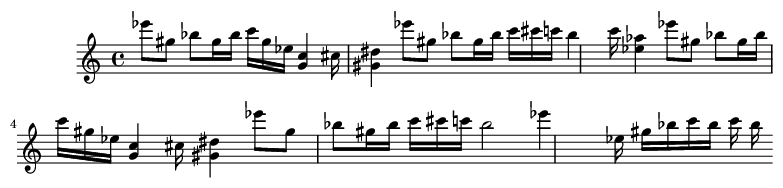

In [201]:
show(melody_midi[:50])

In [202]:
play(melody_midi[:100])

## Simpifying chords and encoding

In [213]:
LIMIT = 8

### Check if removing rare chords helps
types_short = dict() # checking if trimming chords makes any sense at all + creating id for each chord
types_trans = dict() # enables transformation of chords
id = 1
for key, value in types.items(): 
  kcp = key[:9] if value <= LIMIT and len(key) > 9 else key
  types_trans[key] = kcp
  if types_short.get(kcp) is None:
    types_short[kcp] = id
    id += 1

print(len(types), len(types_short))

1881 1176


### Encoding and decoding

In [209]:
notes_list[:10]

[[0.0, '87.0', 0.5],
 [1.0, '80.0', Fraction(1, 3)],
 [2.0, '82.0', Fraction(1, 3)],
 [3.5, '80.0', 0.25],
 [3.75, '82.0', 0.25],
 [4.0, '84.0', 0.25],
 [4.5, '80.0', 0.25],
 [5.0, '75.0', 0.25],
 [5.5, '67.0 72.0', 1.0],
 [6.5, '73.0', 0.25]]

In [223]:
# Warning!!! This method removes rare chords, so the encoded version may not be the same

def encode_part(midi: list, chord_trans: dict, chords_id: dict, empty_id: int = 0) -> list:
  sound_list = list()
  notes = get_all_notes(midi)
  for index, value in enumerate(notes[:-1]):
    cnt = int(value[2] * 12)
    offest_dif = int(12 * (notes[index + 1][0] - value[0]))
    for _ in range(cnt):
      sound_list.append(chords_id[chord_trans[value[1]]])
    for _ in range(max(offest_dif - cnt, 0)):
      sound_list.append(empty_id)
  cnt = int(notes[-1][2] * 12)
  for _ in range(cnt):
      sound_list.append(chords_id[chord_trans[notes[-1][1]]])
  return sound_list

In [248]:
part_encoded = encode_part(midi_list[1], types_trans, types_short)
part_encoded[:20]

[11, 11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 12, 12, 12, 12, 0, 0, 0, 0]

In [238]:
# MADE BY CHATGPT, not sure if correct

def float_to_fraction(x):
    if x.is_integer():
        return int(x)
    else:
        frac = Fraction(x).limit_denominator()
        if frac.denominator == 1:
            return frac.numerator
        elif frac.denominator == 3 and str(frac) == '1/3':
            return frac
        else:
            return x

In [250]:
def decode_part(encoded: list, chords_id_encoder: dict, empty_id: int = 0) -> list:
  notes_decoded = list()
  counter = 0
  zero_counter = 0
  offset = 0.0
  zeros = False
  last_n = encoded[0]
  for n in encoded:
    if n != empty_id and not zeros:
      counter += 1
    elif not n != empty_id and not zeros:
      zeros = not zeros
      zero_counter += 1
    elif (n == empty_id and zeros) or (n != last_n and n != empty_id):
      zeros = not zeros
      notes_decoded.append([offset, chords_id_encoder[last_n], float_to_fraction(counter/12)])
      offset += float((counter + zero_counter) / 12)
      counter = 1
      zero_counter = 0
      last_n = n
  return notes_decoded

In [253]:
reverse_d = {v: k for k, v in types_short.items()}
lst = decode_part(part_encoded, reverse_d)
lst

KeyError: ignored

In [236]:


float_to_fraction(0.25)

0.25

Possible lengths are fractions with a denominator of 12

Time signatures' denominators are always equal to 4 